In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

## Import data

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [4]:
user1 = np.array([0.9,0.8,-0.6])

In [5]:
(user1*last_skywalker).sum()

2.1420000000000003

In [6]:
casablanca = np.array([-0.99,-0.3,0.8])

In [7]:
(user1*casablanca).sum()

-1.611

The above calculation is called a **dot product**

## Creating the DataLoaders

In [8]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


`Collaborative filter` data loader

In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,246,Blown Away (1994),3
1,7,Cyrano de Bergerac (1990),4
2,532,"Fifth Element, The (1997)",3
3,610,Titanic (1997),4
4,660,Chain Reaction (1996),2
5,426,My Man Godfrey (1936),3
6,18,It Happened One Night (1934),5
7,180,Only You (1994),4
8,286,"Island of Dr. Moreau, The (1996)",4
9,715,"American President, The (1995)",3


In [11]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [12]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
one_hot_3 = one_hot(3, n_users).float()

In [14]:
user_factors.t() @ one_hot_3

tensor([-1.4277,  0.9349,  2.1959, -1.0704, -1.2823])

In [15]:
user_factors[3]

tensor([-1.4277,  0.9349,  2.1959, -1.0704, -1.2823])

## Collaborative Filtering from Scratch

In [16]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [17]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [18]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [19]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.224180,1.351329,00:08
1,1.025850,1.087063,00:07
2,0.876332,0.986482,00:07
3,0.785899,0.901360,00:08
4,0.725332,0.876717,00:08


In [20]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

Force predictions to be between 0 and 5 by using sigmoid. `y_range` is `0 to 5.5` because sigmoid times 5 will never hit 5, and make it 5.5 is empirically better 

In [21]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.921236,0.984908,00:08
1,0.647415,0.935821,00:08
2,0.467208,0.939175,00:07
3,0.353536,0.938476,00:08
4,0.347462,0.936419,00:07


One obvious missing piece is that some users are just more positive or negative in their recommendation than others, and some movies are just plain better or worse than others. Our dot product presentation don't have a way to encode either of these things. It is because we only have weights not bias. If we have a single number for each user that we can add to our scores, and the same as for each movie, that will handle this missing piece nicely. 

In [22]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])                         # user embedding
        movies = self.movie_factors(x[:,1])                       # movie embbedding
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [23]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.869012,0.929154,00:08
1,0.566764,0.905329,00:08
2,0.407142,0.935940,00:08
3,0.324502,0.944673,00:08
4,0.311127,0.946141,00:08


It gets worse at the end of training. If we look at both trainings carefully, we can see the validation loss stopped improving in the middle and starts to get worse. This is an indication of overfitting. In this case, there's no way to use data augmentation, so we have to use another regularization technique. One approach that can be helpful is weight decay.

## Weight decay

* Weight decay or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

* Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. 

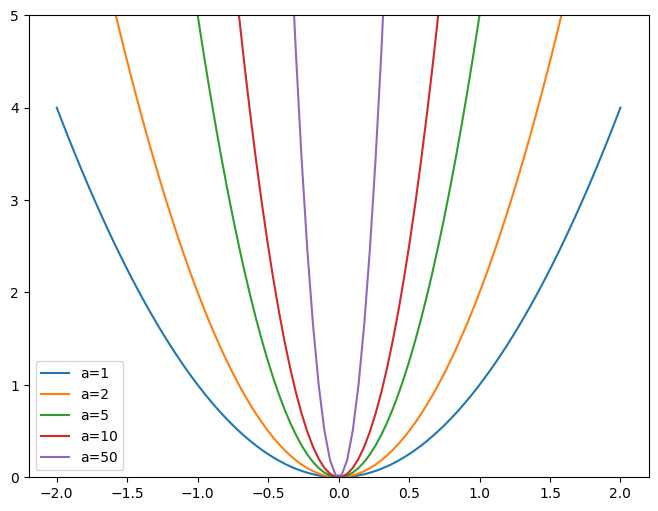

In [24]:
# example of parabola
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.890173,0.944422,00:08
1,0.670918,0.894218,00:08
2,0.537695,0.867216,00:08
3,0.471861,0.853045,00:08
4,0.434248,0.847163,00:08
